In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras.metrics import mean_absolute_percentage_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Univariate Time Series - LSTM

In [3]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/31006-ts/Data/thaitourism2.csv')
df.head()

,region,nationality,year,month,tourists
0,Africa,AfrOthers,2010,1,6553
1,Africa,AfrOthers,2010,2,5618
2,Africa,AfrOthers,2010,3,6689
3,Africa,AfrOthers,2010,4,5210
4,Africa,AfrOthers,2010,5,4537


In [4]:
# Set date as the index of the data frame
df['Month'] = pd.to_datetime(df.year.astype(str) + '/' + df.month.astype(str))
df = df.set_index('Month')
df_us = df[df.nationality == 'USA']
df_us.head()

,region,nationality,year,month,tourists
Month,,,,,
2010-01-01,Americas,USA,2010,1,69238
2010-02-01,Americas,USA,2010,2,58901
2010-03-01,Americas,USA,2010,3,59667
2010-04-01,Americas,USA,2010,4,49775
2010-05-01,Americas,USA,2010,5,34061


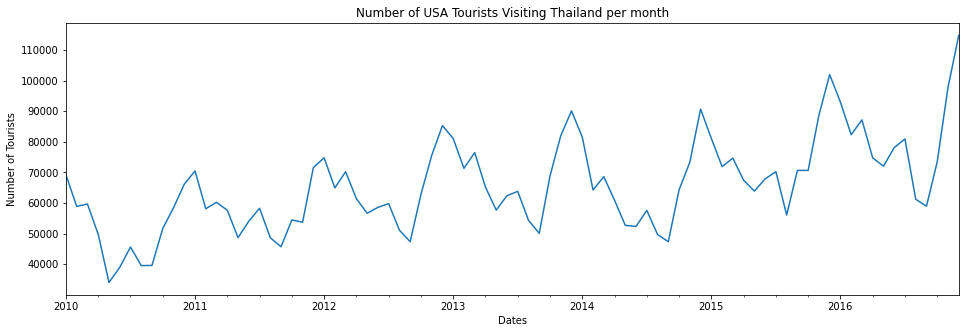

In [5]:
# Convert index to Datetime Index and plot the time series data
df_us.index.freq = 'MS'
ax = df_us['tourists'].plot(figsize = (16,5), title = "Number of USA Tourists Visiting Thailand per month")
ax.set(xlabel='Dates', ylabel='Number of Tourists');

In [6]:
df_sub = df_us[['tourists']]
df_sub.shape

(84, 1)

In [7]:
# train and test split
train = df_sub[:len(df_sub)-12].copy()
test = df_sub[len(df_sub)-12:].copy()

In [8]:
# Normalize the data
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
scaled_train[0:15]

array([[0.51807069],
       [0.36583211],
       [0.3771134 ],
       [0.23142857],
       [0.        ],
       [0.07253314],
       [0.17051546],
       [0.08110457],
       [0.08182622],
       [0.259838  ],
       [0.35930781],
       [0.47300442],
       [0.53658321],
       [0.35460972],
       [0.38562592]])

In [19]:
for i in range(len(generator))[0:2]:
    x, y = generator[i]
    print(x, y)

[[[0.51807069]
  [0.36583211]
  [0.3771134 ]
  [0.23142857]
  [0.        ]
  [0.07253314]
  [0.17051546]
  [0.08110457]
  [0.08182622]
  [0.259838  ]
  [0.35930781]
  [0.47300442]]] [[0.53658321]]
[[[0.36583211]
  [0.3771134 ]
  [0.23142857]
  [0.        ]
  [0.07253314]
  [0.17051546]
  [0.08110457]
  [0.08182622]
  [0.259838  ]
  [0.35930781]
  [0.47300442]
  [0.53658321]]] [[0.35460972]]


In [9]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
lstm_model.fit(generator,epochs=100, verbose = 0)

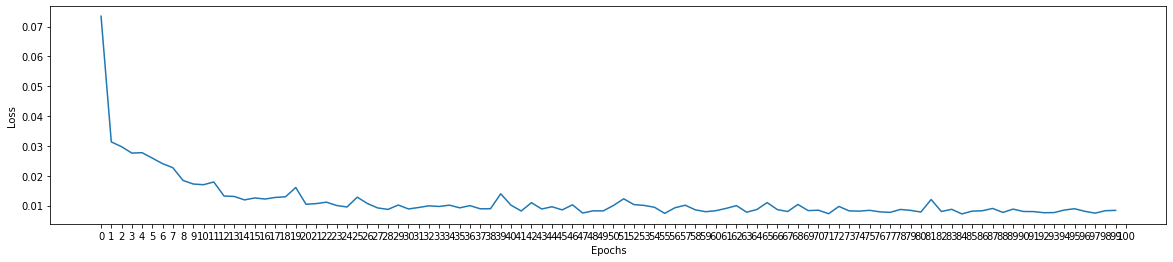

In [11]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(20,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,101,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

In [34]:
scaled_train[-12:]

array([[0.69303387],
       [0.55749632],
       [0.59814433],
       [0.49173785],
       [0.43954345],
       [0.4982327 ],
       [0.5330486 ],
       [0.32443299],
       [0.53911635],
       [0.53911635],
       [0.80506627],
       [1.        ]])

In [35]:
lstm_predictions_scaled = []

batch = scaled_train[-n_input:]   # The last 12 observations in scaled_train
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  lstm_pred = lstm_model.predict(current_batch)[0]
  lstm_predictions_scaled.append(lstm_pred)
  current_batch=np.append(current_batch[:,1:,:], [[lstm_pred]], axis=1)

In [30]:
for i in range(len(test):
  lstm_pred = lstmbatch.reshape((1, n_input, n_features))

array([[[0.69303387],
        [0.55749632],
        [0.59814433],
        [0.49173785],
        [0.43954345],
        [0.4982327 ],
        [0.5330486 ],
        [0.32443299],
        [0.53911635],
        [0.53911635],
        [0.80506627],
        [1.        ]]])

In [13]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[ 91256.73539495],
       [ 82375.2164886 ],
       [ 77580.63649988],
       [ 71287.47581697],
       [ 68131.71045637],
       [ 69303.56834388],
       [ 69403.15264916],
       [ 66473.88633943],
       [ 71901.71663618],
       [ 84422.17459536],
       [102039.66860628],
       [116785.48732853]])

In [14]:
test['LSTM_Uni_Predictions'] = lstm_predictions
test

,tourists,LSTM_Uni_Predictions
Month,,
2016-01-01,92979,91256.735395
2016-02-01,82335,82375.216489
2016-03-01,87174,77580.636500
2016-04-01,74755,71287.475817
2016-05-01,72037,68131.710456
2016-06-01,78114,69303.568344
2016-07-01,80957,69403.152649
2016-08-01,61241,66473.886339
2016-09-01,58954,71901.716636


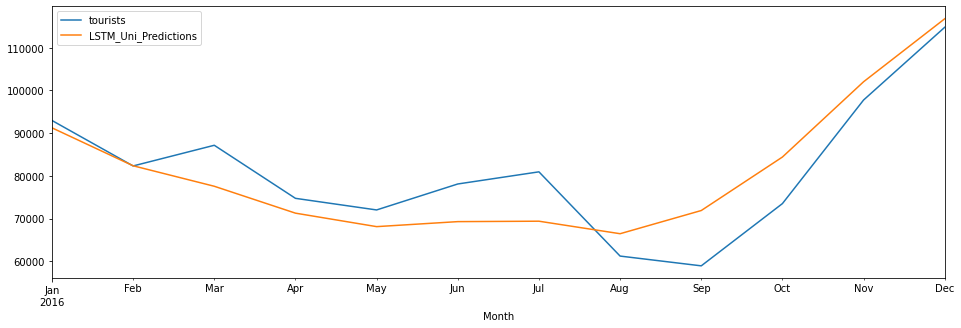

In [15]:
test.tourists.plot(figsize = (16,5), legend = True)
test.LSTM_Uni_Predictions.plot(legend = True)

In [24]:
lstm_rmse_error = mean_squared_error(test.tourists, test.LSTM_Uni_Predictions, squared=False)
lstm_mse_error = mean_squared_error(test.tourists, test.LSTM_Uni_Predictions)
lstm_mape_error = mean_absolute_percentage_error(test.tourists, test.LSTM_Uni_Predictions)

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAPE Error: {lstm_mape_error}')

MSE Error: 55783365.86990858
RMSE Error: 7468.826271236236
MAPE Error: 8.329171587832592
